In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import psycopg2 as pg2
import re

In [2]:
conn = pg2.connect(dbname='medicare', user='postgres')

In [3]:
query = '''
        SELECT *
        FROM util_payments_agg_2013;
        '''

In [72]:
df_util = pd.read_sql_query(query, conn)

In [7]:
df_util.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956293 entries, 0 to 956292
Data columns (total 68 columns):
index                                       956293 non-null int64
npi                                         956293 non-null int64
last_name                                   956275 non-null object
first_name                                  898288 non-null object
middle_initial                              678408 non-null object
credentials                                 873126 non-null object
gender                                      898293 non-null object
entity_code                                 956293 non-null object
street1                                     956291 non-null object
street2                                     392669 non-null object
city                                        956291 non-null object
zip                                         956293 non-null object
state                                       956293 non-null object
country             

In [8]:
df_util.columns

Index([u'index', u'npi', u'last_name', u'first_name', u'middle_initial',
       u'credentials', u'gender', u'entity_code', u'street1', u'street2',
       u'city', u'zip', u'state', u'country', u'provider_type',
       u'medicare_participation_indicator', u'num_hcpcs', u'num_services',
       u'num_unique_bene', u'total_submitted_charges',
       u'total_medicare_allowed_amt', u'total_medicare_payment_amt',
       u'drug_suppress_indicator', u'num_hcpcs_associated_drug_srvc',
       u'num_drug_srvc', u'num_unique_bene_with_drug_srvc',
       u'total_drug_submitted_charges', u'total_drug_medicare_allowed_amt',
       u'total_drug_medicare_payment_amt', u'medical_suppress_indicator',
       u'num_hcpcs_associated_med_srvc', u'num_med_srvc',
       u'num_unique_bene_with_med_srvc', u'total_med_submitted_charges',
       u'total_med_medicare_allowed_amt', u'total_med_medicare_payment_amt',
       u'avg_age_bene', u'num_bene_le65', u'num_bene_65to74',
       u'num_bene_75to84', u'num_bene_ge

In [9]:
drop_cols = ['index', 
             'middle_initial', 
             'street1',
             'street2',
             'country',
             'medicare_participation_indicator',
             'num_medicare_only',
             'num_medicare_medicaid']

In [73]:
df_util['credentials'].fillna('None', inplace=True)

In [74]:
df_util['credentials'] = df_util['credentials'].apply(lambda x: x.replace('.', ''))

In [75]:
df_util['gender'].fillna('None', inplace=True)

In [76]:
df_util['entity_code'].value_counts()

I    898293
O     58000
Name: entity_code, dtype: int64

In [77]:
df_util['zip'].head()

0    215021854
1    602011718
2    436233536
3    166681219
4    441061716
Name: zip, dtype: object

In [78]:
np.sum(df_util['zip'].apply(lambda x: x.isdigit()))

956270

Drop zip codes that are not all numeric. Armed forces postal codes, etc... There are only a handful of them

In [79]:
df_util = df_util[df_util['zip'].apply(lambda x: x.isdigit())]

In [80]:
df_util['zip_1'] = df_util['zip'].apply(lambda x: x[0:5])

In [81]:
df_util['zip_suffix'] = df_util['zip'].apply(lambda x: x[5:9])

Drop all rows with country outside of US. There are only a handful

In [82]:
df_util['country'][df_util['country']!='US'].value_counts()

DE    15
JP     7
TR     5
SA     4
IL     3
PK     2
VE     2
MX     1
AE     1
CN     1
IS     1
CO     1
HU     1
AU     1
IN     1
BR     1
KY     1
GB     1
IT     1
NO     1
KP     1
KR     1
NZ     1
PA     1
KW     1
FR     1
Name: country, dtype: int64

In [83]:
df_util = df_util[df_util['country']=='US']

In [84]:
df_util.shape

(956213, 70)

In [236]:
df_util['state'].value_counts()

CA    77824
NY    68360
TX    59181
FL    57541
PA    48703
IL    40237
OH    38239
MI    35389
NC    30980
MA    30868
NJ    30073
GA    25458
VA    23240
WA    22750
MN    21837
TN    21724
WI    21204
MD    20025
MO    19387
IN    19295
AZ    18302
CO    14989
CT    14189
KY    14106
SC    13377
AL    13000
LA    12960
OR    11919
IA    10418
OK    10308
KS     9713
AR     7516
MS     7487
UT     6794
NE     6740
ME     6306
WV     6212
NV     6063
PR     5887
NH     5681
NM     5654
ID     4623
RI     4400
MT     3580
SD     3543
DE     3398
HI     3308
ND     3207
DC     3040
VT     2707
AK     2300
WY     1798
Name: state, dtype: int64

Includes some territories in the 'states' column. Proceed for now, drop later if necessary. Again, not that many.  
Drop territories

In [241]:
drop_territories = ['VI', 'GU', 'MP', 'AE', 'AP', 'AA', 'AS', 'XX', 'PR']
df_util = df_util[-df_util['state'].isin(drop_territories)]

In [87]:
df_util.provider_type.value_counts()

Internal Medicine                           95645
Family Practice                             81177
Nurse Practitioner                          64694
Physician Assistant                         50122
Emergency Medicine                          39274
Physical Therapist                          39263
CRNA                                        37865
Chiropractic                                37061
Anesthesiology                              36531
Diagnostic Radiology                        29334
Mass Immunization Roster Biller             28782
Optometry                                   27898
Obstetrics/Gynecology                       27770
Cardiology                                  22780
Psychiatry                                  22708
Orthopedic Surgery                          21202
General Surgery                             19860
Ophthalmology                               17550
Licensed Clinical Social Worker             15360
Podiatry                                    14789


Lots of different specialty/provider types. May have to bin later.

Change both 'suppress indicators' to 1 for true, 0 for false. Columns indicate redactions for less than 11

In [88]:
df_util['drug_suppress_indicator'].value_counts()

*    100726
#        49
Name: drug_suppress_indicator, dtype: int64

In [89]:
df_util['drug_suppress_indicator'] = [0 if value is None else 1 for value in df_util['drug_suppress_indicator']]

In [92]:
df_util['drug_suppress_indicator'].value_counts()

0    855438
1    100775
Name: drug_suppress_indicator, dtype: int64

In [93]:
df_util['medical_suppress_indicator'] = [0 if value is None else 1 for value in df_util['medical_suppress_indicator']]

In [94]:
df_util['medical_suppress_indicator'].value_counts()

0    855438
1    100775
Name: medical_suppress_indicator, dtype: int64

## Drug services nulls
```
num_hcpcs_associated_drug_srvc              855508 non-null float64
num_drug_srvc                               855508 non-null float64
num_unique_bene_with_drug_srvc              855508 non-null float64
total_drug_submitted_charges                855508 non-null float64
total_drug_medicare_allowed_amt             855508 non-null float64
total_drug_medicare_payment_amt             855508 non-null float64
```

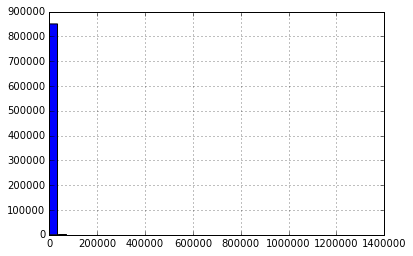

In [98]:
df_util['num_drug_srvc'].hist(bins=40)

In [104]:
df_util['total_drug_medicare_allowed_amt'].describe()

count      855438.000000
mean        13797.955352
std        162972.742051
min             0.000000
25%             0.000000
50%             0.000000
75%           328.907500
max      36293148.000000
Name: total_drug_medicare_allowed_amt, dtype: float64

In [105]:
df_util['num_hcpcs_associated_drug_srvc'].value_counts()

0      609609
4       31220
3       30335
5       27938
2       27852
6       25394
7       19416
1       15258
8       13973
9       10780
10       8537
11       6772
12       5385
13       4109
14       3180
15       2497
16       1822
17       1406
18       1011
19        761
20        611
21        496
22        360
23        303
24        244
25        216
26        175
28        147
64        145
27        143
        ...  
82         39
80         39
85         32
86         32
83         32
84         31
87         23
89         23
88         19
90         18
91         18
93         14
94         13
96         11
97         10
95          9
92          9
100         5
102         4
98          3
101         3
107         2
103         2
106         2
110         1
108         1
112         1
105         1
99          1
118         1
Name: num_hcpcs_associated_drug_srvc, dtype: int64

Doesn't seem to be that much information here. More than half of the values are just 0. Maybe bin 0 vs not 0

In [111]:
df_util['drug_srvc_bin'] = [0 if col==0 else 1 for col in df_util['num_drug_srvc']]

In [107]:
drug_srvc_cols = ['num_hcpcs_associated_drug_srvc',
                  'num_drug_srvc',
                  'num_unique_bene_with_drug_srvc',
                  'total_drug_submitted_charges',
                  'total_drug_medicare_allowed_amt',
                  'total_drug_medicare_payment_amt']

In [108]:
df_util[drug_srvc_cols][df_util['num_hcpcs_associated_drug_srvc']==0]

,num_hcpcs_associated_drug_srvc,num_drug_srvc,num_unique_bene_with_drug_srvc,total_drug_submitted_charges,total_drug_medicare_allowed_amt,total_drug_medicare_payment_amt
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
5,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0
10,0,0,0,0,0,0
11,0,0,0,0,0,0
12,0,0,0,0,0,0


In [109]:
df_util['total_drug_submitted_charges'] + df_util['total_med_submitted_charges']


0           395335.00
1          1211595.00
2           197224.00
3           240818.00
4                 NaN
5           338191.00
6                 NaN
7           123045.00
8            52661.00
9             3680.00
10          175121.25
11           82738.20
12           12489.00
13          109996.00
14           56122.00
15            8890.31
16          303794.40
17          188091.00
18          247650.00
19           93883.68
20           88530.42
21            8372.00
22           21716.91
23         3739507.46
24          170987.50
25         7268429.00
26           34953.00
27                NaN
28          671573.20
29           12330.00
             ...     
956263       22828.66
956264        8653.06
956265      486850.00
956266            NaN
956267       21133.00
956268       18336.00
956269       14304.60
956270        5604.00
956271        8965.00
956272    33169170.00
956273     2114190.04
956274        2425.00
956275      130768.00
956276       77230.00
956277    

In [110]:
df_util['total_submitted_charges']

0           395335.00
1          1211595.00
2           197224.00
3           240818.00
4            31637.00
5           338191.00
6           173219.65
7           123045.00
8            52661.00
9             3680.00
10          175121.25
11           82738.20
12           12489.00
13          109996.00
14           56122.00
15            8890.31
16          303794.40
17          188091.00
18          247650.00
19           93883.68
20           88530.42
21            8372.00
22           21716.91
23         3739507.46
24          170987.50
25         7268429.00
26           34953.00
27          133631.00
28          671573.20
29           12330.00
             ...     
956263       22828.66
956264        8653.06
956265      486850.00
956266      256612.00
956267       21133.00
956268       18336.00
956269       14304.60
956270        5604.00
956271        8965.00
956272    33169170.00
956273     2114190.04
956274        2425.00
956275      130768.00
956276       77230.00
956277    

### 'Total' charges are a sum of the drug charges and the medical services charges

Just look at total charges for now, drop broken out drug/medical charges

## Exploration of demographic variables
```
num_unique_bene                             956293 non-null int64
avg_age_bene                                956293 non-null float64
num_bene_le65                               652491 non-null float64
num_bene_65to74                             803528 non-null float64
num_bene_75to84                             694141 non-null float64
num_bene_ge84                               589192 non-null float64
num_female                                  854854 non-null float64
num_male                                    854854 non-null float64
num_non_his_white                           629147 non-null float64
num_african_american                        319244 non-null float64
num_asian                                   165528 non-null float64
num_hispanic                                250582 non-null float64
num_american_indian                         263435 non-null float64
num_no_race                                 126199 non-null float64
num_medicare_only                           726453 non-null float64
num_medicare_medicaid                       726453 non-null float64
pcnt_alzheimers_dementia                    633056 non-null float64
pcnt_asthma                                 603736 non-null float64
pcnt_artrial_fibrillation                   650309 non-null float64
pcnt_cancer                                 646550 non-null float64
pcnt_chronic_kidney                         752279 non-null float64
pcnt_chronic_obstructive_pulmonary          699972 non-null float64
pcnt_depression                             800406 non-null float64
pcnt_diabetes                               822613 non-null float64
pcnt_heart_failure                          721405 non-null float64
pcnt_hyperlipidemia                         886581 non-null float64
pcnt_hypertension                           906330 non-null float64
pcnt_ischemic_heart                         819432 non-null float64
pcnt_osteoporosis                           604753 non-null float64
pcnt_rheumatoid_arthritis_osteoarthirtis    857849 non-null float64
pcnt_schizophrenia_psychotic                503777 non-null float64
pcnt_stroke                                 533130 non-null float64
avg_hcc_risk_score                          956293 non-null float64
```

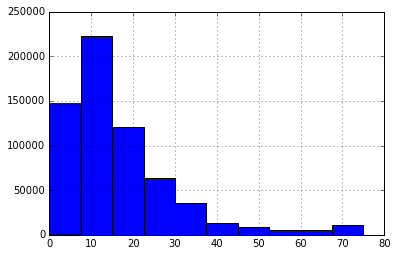

In [122]:
df_util['pcnt_alzheimers_dementia'].hist()

In [124]:
df_util['num_female'] + df_util['num_male']

0           665
1          3940
2           144
3           436
4            63
5           146
6           539
7           306
8           NaN
9            41
10          NaN
11          102
12           28
13           42
14           56
15          NaN
16          654
17          596
18          322
19           76
20           72
21          NaN
22          401
23          806
24          139
25          204
26           42
27          160
28          231
29          NaN
          ...  
956263       70
956264      126
956265      215
956266      320
956267       36
956268       48
956269      NaN
956270       49
956271      NaN
956272    15030
956273     1028
956274      NaN
956275      188
956276       73
956277       65
956278      345
956279      302
956280       74
956281      NaN
956282       27
956283      224
956284       25
956285     1230
956286       85
956287      132
956288       60
956289      NaN
956290      103
956291      452
956292      439
dtype: float64

In [125]:
df_util['num_unique_bene']

0           665
1          3940
2           144
3           436
4            63
5           146
6           539
7           306
8            14
9            41
10           25
11          102
12           28
13           42
14           56
15           20
16          654
17          596
18          322
19           76
20           72
21           44
22          401
23          806
24          140
25          204
26           42
27          160
28          231
29           12
          ...  
956263       70
956264      126
956265      215
956266      320
956267       36
956268       48
956269       16
956270       49
956271       19
956272    15030
956273     1028
956274       17
956275      188
956276       73
956277       65
956278      345
956279      302
956280       74
956281       14
956282       27
956283      224
956284       25
956285     1230
956286       85
956287      132
956288       60
956289       23
956290      103
956291      452
956292      439
Name: num_unique_bene, d

female + male add up to unique beneficiaries, unless null

#### Race variables

```
num_non_his_white                           629147 non-null float64
num_african_american                        319244 non-null float64
num_asian                                   165528 non-null float64
num_hispanic                                250582 non-null float64
num_american_indian                         263435 non-null float64
num_no_race                                 126199 non-null float64
```

In [143]:
np.sum(df_util['num_no_race']) / (np.sum(df_util['num_non_his_white'])+np.sum(df_util['num_african_american'])+np.sum(df_util['num_asian'])
                                 +np.sum(df_util['num_hispanic']) + np.sum(df_util['num_african_american']))

0.004361626310475491

Num_no_race seems fairly inconsequential, will just fill nulls with the minimum value of 1

In [144]:
df_util['num_no_race'].fillna(1, inplace=True)

In [176]:
race_cols = ['state',
             'num_unique_bene',
             'num_non_his_white',
             'num_african_american',
             'num_asian',
             'num_hispanic',
             'num_american_indian',
             'num_no_race']

In [133]:
df_util[race_cols].sum(axis=1)

0           653
1          3940
2           109
3             0
4             0
5           123
6           517
7           295
8             0
9             0
10            0
11            0
12           12
13            0
14            0
15           20
16          639
17          400
18          307
19            0
20            0
21           21
22            0
23          787
24          127
25          153
26            0
27          144
28          213
29            0
          ...  
956263       49
956264      110
956265      186
956266      308
956267        0
956268       37
956269        0
956270        0
956271        0
956272    15030
956273     1013
956274        0
956275      164
956276        0
956277        0
956278      317
956279      282
956280       57
956281       14
956282        0
956283      203
956284       12
956285     1218
956286       71
956287      120
956288        0
956289        0
956290        0
956291      441
956292      295
dtype: float64

In [134]:
df_util['num_unique_bene']

0           665
1          3940
2           144
3           436
4            63
5           146
6           539
7           306
8            14
9            41
10           25
11          102
12           28
13           42
14           56
15           20
16          654
17          596
18          322
19           76
20           72
21           44
22          401
23          806
24          140
25          204
26           42
27          160
28          231
29           12
          ...  
956263       70
956264      126
956265      215
956266      320
956267       36
956268       48
956269       16
956270       49
956271       19
956272    15030
956273     1028
956274       17
956275      188
956276       73
956277       65
956278      345
956279      302
956280       74
956281       14
956282       27
956283      224
956284       25
956285     1230
956286       85
956287      132
956288       60
956289       23
956290      103
956291      452
956292      439
Name: num_unique_bene, d

In [145]:
df_util[race_cols].iloc[0]

num_non_his_white       639
num_african_american     14
num_asian               NaN
num_hispanic            NaN
num_american_indian       0
num_no_race               1
Name: 0, dtype: float64

### Need to impute some of the values of race nulls  
First strategy, use the percentage in the state

In [137]:
df_state_dem = pd.read_csv('/home/ubuntu/medicare-project/state_race_data_clean.csv')

In [139]:
df_state_dem.fillna(0, inplace=True)

In [150]:
df_state_dem

,Location,White,Black,Hispanic,Asian,American Indian/Alaska Native,Two Or More Races,Total
0,US,0.62,0.12,0.18,0.06,0.01,0.02,1
1,Alabama,0.66,0.27,0.04,0.02,0.00,0.01,1
2,Alaska,0.57,0.02,0.09,0.10,0.16,0.07,1
3,Arizona,0.49,0.04,0.39,0.04,0.03,0.01,1
4,Arkansas,0.72,0.16,0.07,0.00,0.01,0.02,1
5,California,0.39,0.05,0.38,0.15,0.01,0.02,1
6,Colorado,0.70,0.04,0.21,0.02,0.00,0.02,1
7,Connecticut,0.71,0.09,0.13,0.06,0.00,0.01,1
8,Delaware,0.63,0.20,0.10,0.04,0.00,0.02,1
9,District of Columbia,0.37,0.47,0.11,0.04,0.00,0.02,1


In [148]:
# Convert state to 2 letter abbreviation

In [151]:
df_state_dem['Location'].iloc[0] = 'US'
df_state_dem['Location'].iloc[1] = 'AL'
df_state_dem['Location'].iloc[2] = 'AK'
df_state_dem['Location'].iloc[3] = 'AZ'
df_state_dem['Location'].iloc[4] = 'AR'
df_state_dem['Location'].iloc[5] = 'CA'
df_state_dem['Location'].iloc[6] = 'CO'
df_state_dem['Location'].iloc[7] = 'CT'
df_state_dem['Location'].iloc[8] = 'DE'
df_state_dem['Location'].iloc[9] = 'DC'
df_state_dem['Location'].iloc[10] = 'FL'
df_state_dem['Location'].iloc[11] = 'GA'
df_state_dem['Location'].iloc[12] = 'HI'
df_state_dem['Location'].iloc[13] = 'ID'
df_state_dem['Location'].iloc[14] = 'IL'
df_state_dem['Location'].iloc[15] = 'IN'
df_state_dem['Location'].iloc[16] = 'IA'
df_state_dem['Location'].iloc[17] = 'KS'
df_state_dem['Location'].iloc[18] = 'KY'
df_state_dem['Location'].iloc[19] = 'LA'
df_state_dem['Location'].iloc[20] = 'ME'
df_state_dem['Location'].iloc[21] = 'MD'
df_state_dem['Location'].iloc[22] = 'MA'
df_state_dem['Location'].iloc[23] = 'MI'
df_state_dem['Location'].iloc[24] = 'MN'
df_state_dem['Location'].iloc[25] = 'MS'
df_state_dem['Location'].iloc[26] = 'MO'
df_state_dem['Location'].iloc[27] = 'MT'
df_state_dem['Location'].iloc[28] = 'NE'
df_state_dem['Location'].iloc[29] = 'NV'
df_state_dem['Location'].iloc[30] = 'NH'
df_state_dem['Location'].iloc[31] = 'NJ'
df_state_dem['Location'].iloc[32] = 'NM'
df_state_dem['Location'].iloc[33] = 'NY'
df_state_dem['Location'].iloc[34] = 'NC'
df_state_dem['Location'].iloc[35] = 'ND'
df_state_dem['Location'].iloc[36] = 'OH'
df_state_dem['Location'].iloc[37] = 'OK'
df_state_dem['Location'].iloc[38] = 'OR'
df_state_dem['Location'].iloc[39] = 'PA'
df_state_dem['Location'].iloc[40] = 'RI'
df_state_dem['Location'].iloc[41] = 'SC'
df_state_dem['Location'].iloc[42] = 'SD'
df_state_dem['Location'].iloc[43] = 'TN'
df_state_dem['Location'].iloc[44] = 'TX'
df_state_dem['Location'].iloc[45] = 'UT'
df_state_dem['Location'].iloc[46] = 'VT'
df_state_dem['Location'].iloc[47] = 'VA'
df_state_dem['Location'].iloc[48] = 'WA'
df_state_dem['Location'].iloc[49] = 'WV'
df_state_dem['Location'].iloc[50] = 'WI'
df_state_dem['Location'].iloc[51] = 'WY'


In [155]:
df_state_dem

,state,num_non_hist_white,num_african_american,num_hispanic,num_asian,num_american_indian,num_two_more,total
0,US,0.62,0.12,0.18,0.06,0.01,0.02,1
1,AL,0.66,0.27,0.04,0.02,0.00,0.01,1
2,AK,0.57,0.02,0.09,0.10,0.16,0.07,1
3,AZ,0.49,0.04,0.39,0.04,0.03,0.01,1
4,AR,0.72,0.16,0.07,0.00,0.01,0.02,1
5,CA,0.39,0.05,0.38,0.15,0.01,0.02,1
6,CO,0.70,0.04,0.21,0.02,0.00,0.02,1
7,CT,0.71,0.09,0.13,0.06,0.00,0.01,1
8,DE,0.63,0.20,0.10,0.04,0.00,0.02,1
9,DC,0.37,0.47,0.11,0.04,0.00,0.02,1


In [213]:
df_state_dem.columns = ['state', 'num_non_his_white', 'num_african_american', 
                        'num_hispanic', 'num_asian', 'num_american_indian', 'num_two_more', 'total']

In [172]:
df_util[race_cols].iloc[0][df_util[race_cols].iloc[0].isnull()==True].index

Index([u'num_asian', u'num_hispanic'], dtype='object')

In [255]:
def impute_dem(row, df_state):
    state = row['state']
    mask_race_sum = [
                     'num_non_his_white',
                     'num_african_american',
                     'num_asian',
                     'num_hispanic',
                     'num_american_indian',
                     'num_no_race']
    num_missing = row['num_unique_bene'] - (row[mask_race_sum].sum())
    if num_missing == 0:
        return row
    else:
        missing_cols = row[row.isnull()==True].index
        norm_percent = df_state[df_state['state']==state][missing_cols].sum(axis=1)

        for col in missing_cols:
            row[col] = round((df_state[df_state['state']==state][col]/norm_percent) * num_missing)
        return row

In [220]:
impute_dem(df_util[race_cols].iloc[0], df_state_dem)

state                    MD
num_unique_bene         665
num_non_his_white       639
num_african_american     14
num_asian                 5
num_hispanic              6
num_american_indian       0
num_no_race               1
Name: 0, dtype: object

In [221]:
df_util[race_cols].iloc[0].isnull().any()

True

In [257]:
df_util[race_cols].iloc[0]

state                    MD
num_unique_bene         665
num_non_his_white       639
num_african_american     14
num_asian                 5
num_hispanic              6
num_american_indian       0
num_no_race               1
Name: 0, dtype: object

In [ ]:
df_util[race_cols] = df_util[race_cols].apply(lambda x: impute_dem(x, df_state_dem), axis=1)

In [243]:
#for _, row in df_util[race_cols].iterrows():
    if row.isnull().any():
        row = impute_dem(row, df_state_dem)

KeyboardInterrupt: 

In [277]:
df_util.iloc[949952][race_cols]

state                    VA
num_unique_bene         439
num_non_his_white       295
num_african_american     80
num_asian                29
num_hispanic             34
num_american_indian       0
num_no_race               1
Name: 956292, dtype: object

In [274]:
df_util.shape

(949953, 71)

In [278]:
df_util.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949953 entries, 0 to 956292
Data columns (total 71 columns):
index                                       949953 non-null int64
npi                                         949953 non-null int64
last_name                                   949935 non-null object
first_name                                  892714 non-null object
middle_initial                              674888 non-null object
credentials                                 949953 non-null object
gender                                      949953 non-null object
entity_code                                 949953 non-null object
street1                                     949953 non-null object
street2                                     388557 non-null object
city                                        949952 non-null object
zip                                         949953 non-null object
state                                       949953 non-null object
country             

In [279]:
df_util.to_csv('/home/ubuntu/medicare-project/data/medicare_util_pay_agg_race_clean.csv')